In [ ]:
%load_ext autoreload
%autoreload 2

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import datetime
import copy
import time
import pandas as pd
import sys
import os
sys.path.append('../../')

import models

from main.seir.fitting import single_fitting_cycle
from main.seir.forecast import get_forecast, forecast_all_trials, create_all_trials_csv, create_decile_csv_new
from utils.generic.create_report import save_dict_and_create_report
from utils.generic.config import read_config, make_date_key_str
from utils.generic.enums import Columns
from utils.fitting.loss import Loss_Calculator
from utils.generic.logging import log_wandb, log_mlflow
from viz import plot_forecast, plot_top_k_trials, plot_ptiles

import yaml
import wandb

In [ ]:
predictions_dict = {}

In [18]:
config_filename = 'exp_simulate_2.yaml'
config = read_config(config_filename)

wandb_config = read_config(config_filename, preprocess=False)
wandb_config = make_date_key_str(wandb_config)

In [19]:
timestamp = datetime.datetime.now()
output_folder = '../../misc/reports/{}'.format(timestamp.strftime("%Y_%m%d_%H%M%S"))

## Perform M1 and M2 fits

In [ ]:
import matplotlib.pyplot as plt
plt.rcParams.update({
    'text.usetex': False,
    'font.size': 12,
    'font.family': 'Palatino',
})

In [ ]:

# scenario_dict ={}   
# for i in range(7):
#     file_name = '../../misc/predictions/exp_{}.pickle'.format(i)
#     with open(file_name, 'rb') as handle:
#         PD = pkl.load(handle)
#     scenario_dict['exp'+str(i)] = PD['m1']
# with open('../../misc/predictions/scenario_dict.pickle', 'wb') as handle:
#     pkl.dump(scenario_dict, handle)

In [ ]:
with open('../../misc/predictions/exp4.pickle', 'rb') as handle:
        PD = pkl.load(handle)

In [ ]:
scenario_dict['exp4'] = PD['m1']

In [ ]:
figs, axs = plt.subplots(2,4,figsize = [18,10])
arr = ['lockdown_R0', 'T_inc', 'T_inf', 'T_recov', 'T_recov_fatal', 'P_fatal', 'E_hosp_ratio', 'I_hosp_ratio']
plot_2_histogram(scenario_dict,'exp0','exp4',arr,true_val,figs,axs)


In [ ]:
import pickle as pkl
with open('../../misc/predictions/exp_5.pickle', 'rb') as handle:
        PD = pkl.load(handle)

In [ ]:
def update_hosp_ratios(param_set, data_config, model_config):
    df = pd.read_csv(os.path.join('../../data/data/simulated_data/', data_config['output_file_name']), index_col=0)
    if model_config['end_date']:
        # print(model_config['end_date'])
        if isinstance(model_config['end_date'], int):
            if end_date > 0:
                raise ValueError('Please enter a negative value for end_date if entering an integer')
        if isinstance(model_config['end_date'], datetime.date):
            df['date'] = pd.to_datetime(df['date'])
            end_date = df.loc[df['date'].dt.date == model_config['end_date']].index[0] - len(df) + 1
    else:
        end_date = 0
    train_start_row = df.iloc[len(df) - (model_config['train_period'] + model_config['val_period'] + model_config['test_period']) + end_date]
    if data_config['model'] == 'SEIRHD':
        param_set['E_hosp_ratio'] = train_start_row['E'] / train_start_row['active']
        param_set['I_hosp_ratio'] = train_start_row['I'] / train_start_row['active']
    elif data_config['model'] == 'SEIRHD_Beta':
        param_set['E_hosp_ratio'] = train_start_row['E'] / train_start_row['active']
        param_set['I_hosp_ratio'] = train_start_row['I'] / train_start_row['active']
    elif data_config['model'] == 'SEIR_PU':
        param_set['E_hosp_ratio'] = train_start_row['E'] / train_start_row['active']
        param_set['I_hosp_ratio'] = train_start_row['I'] / train_start_row['active']
        param_set['Pu_pop_ratio'] = train_start_row['Pu'] / train_start_row['']
    return param_set

In [ ]:
filename = 'seirhd_fixed.yaml'
with open(f'../../configs/simulated_data/{filename}') as configfile:
        data_config = yaml.load(configfile, Loader=yaml.SafeLoader)
true_val = data_config['params']
# true_val = update_hosp_ratios(true_val,data_config,config['fitting']['split'])
print(true_val)
true_val['P_fatal'] = 0.08

In [ ]:
figs, axs = plt.subplots(2,4,figsize = [18,9])
from viz.fit import plot_histogram,plot_all_histogram,plot_2_histogram,plot_log_density
arr = ['lockdown_R0', 'T_inc', 'T_inf', 'T_recov', 'T_recov_fatal', 'P_fatal', 'E_hosp_ratio', 'I_hosp_ratio']
plot_log_density(PD['m1'],arr,true_val,figs,axs)

In [ ]:
figs, axs = plt.subplots(2,4,figsize = [20,10])
plot_histogram(PD['m1'],arr,true_val,figs,axs)

In [ ]:
from unidip import UniDip
import pandas as pd
arr = list(true_val.keys())

In [ ]:

import pickle as pkl
with open('../../misc/predictions/exp_11.pickle', 'rb') as handle:
        PD = pkl.load(handle)
from main.seir.forecast import _order_trials_by_loss
params_array, losses_array = _order_trials_by_loss(PD['m1'])
params_dict = {param: [param_dict[param] for param_dict in params_array]
                for param in arr}
df = pd.DataFrame.from_dict(params_dict)


In [ ]:
plt.rcParams.update({
    'text.usetex': False,
    'font.size': 18,
    'font.family': 'Palatino',
})

In [ ]:
import seaborn as sns
CM = df.corr()
fig = plt.figure(figsize = (18,15))
heatmap = sns.heatmap(df.corr(), vmin=-1, vmax=1, annot=True,cmap = 'coolwarm')

In [ ]:
sns.pairplot(df)

In [ ]:
((CM.abs().mean()*8 - 1)/7).sort_values(ascending = False)

In [ ]:
# for i in arr:
#     R_0 = df[i].to_numpy()
#     R_0 = np.msort(R_0)
#     interavals = UniDip(R_0,alpha=0.0000001, ntrials=1000).run()
#     print(i,interavals)

  0%|          | 0/10000 [00:00<?, ?it/s]

Performing m1 fit ..
parameters used to generate data: {'beta': 0.25, 'T_inc': 5.1, 'T_inf': 6.6, 'T_recov': 14, 'T_recov_fatal': 10, 'P_fatal': 0.03, 'E_hosp_ratio': 1.0, 'I_hosp_ratio': 1.0}
splitting data ..
splitting data ..
train
 +-------------+---------------------+---------------------+---------------------+---------------------+---------------------+
|             | 324                 | 325                 | 326                 | 327                 | 328                 |
|-------------+---------------------+---------------------+---------------------+---------------------+---------------------|
| date        | 2020-11-20 00:00:00 | 2020-11-21 00:00:00 | 2020-11-22 00:00:00 | 2020-11-23 00:00:00 | 2020-11-24 00:00:00 |
| active      | 475031.71           | 461450.86           | 447639.0            | 434475.0            | 421540.0            |
| total       | 6178114.0           | 6198231.0           | 6219055.0           | 6237639.0           | 6255512.0           |
| recove

  0%|          | 7/4000 [00:00<01:02, 64.21it/s]

The acceptance ratio is -------->  0.1259
The explored steps are -------->  51
The optimized steps are -------->  1208
Gelman-Rubin convergence statistics (variance ratios):
{   'E_hosp_ratio': 1.0918517097925151,
    'I_hosp_ratio': 1.1161973173226465,
    'P_fatal': 2.493963121887679,
    'T_inc': 1.011629434160171,
    'T_inf': 1.080990240324435,
    'T_recov': 1.4142580261643791,
    'T_recov_fatal': 1.2841989436695105,
    'beta': 1.0035249944099631,
    'gamma': 1.6787190188118033}


100%|██████████| 4000/4000 [01:02<00:00, 63.52it/s]


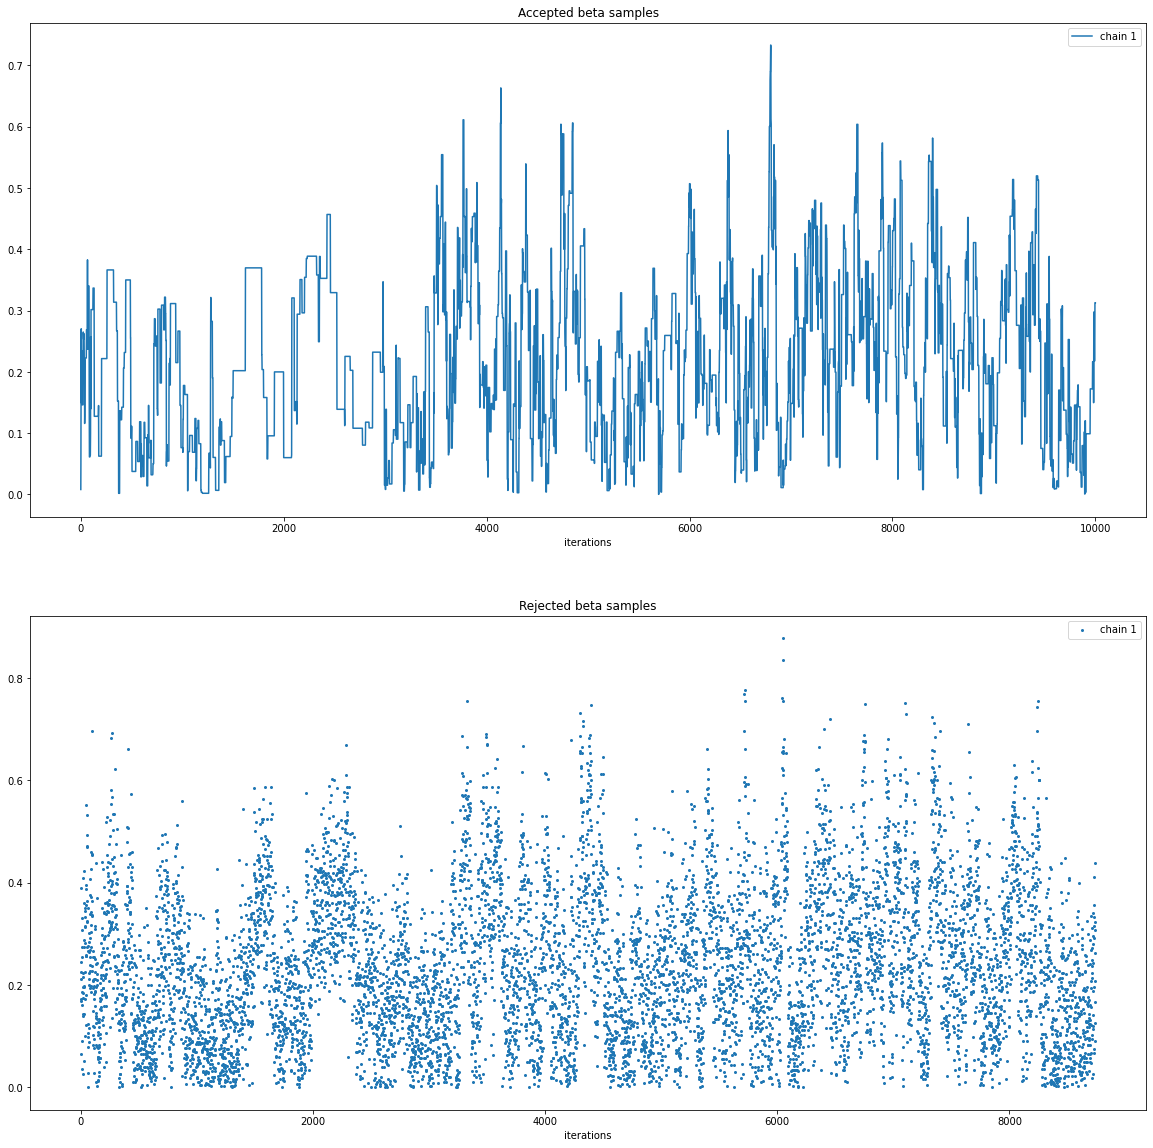

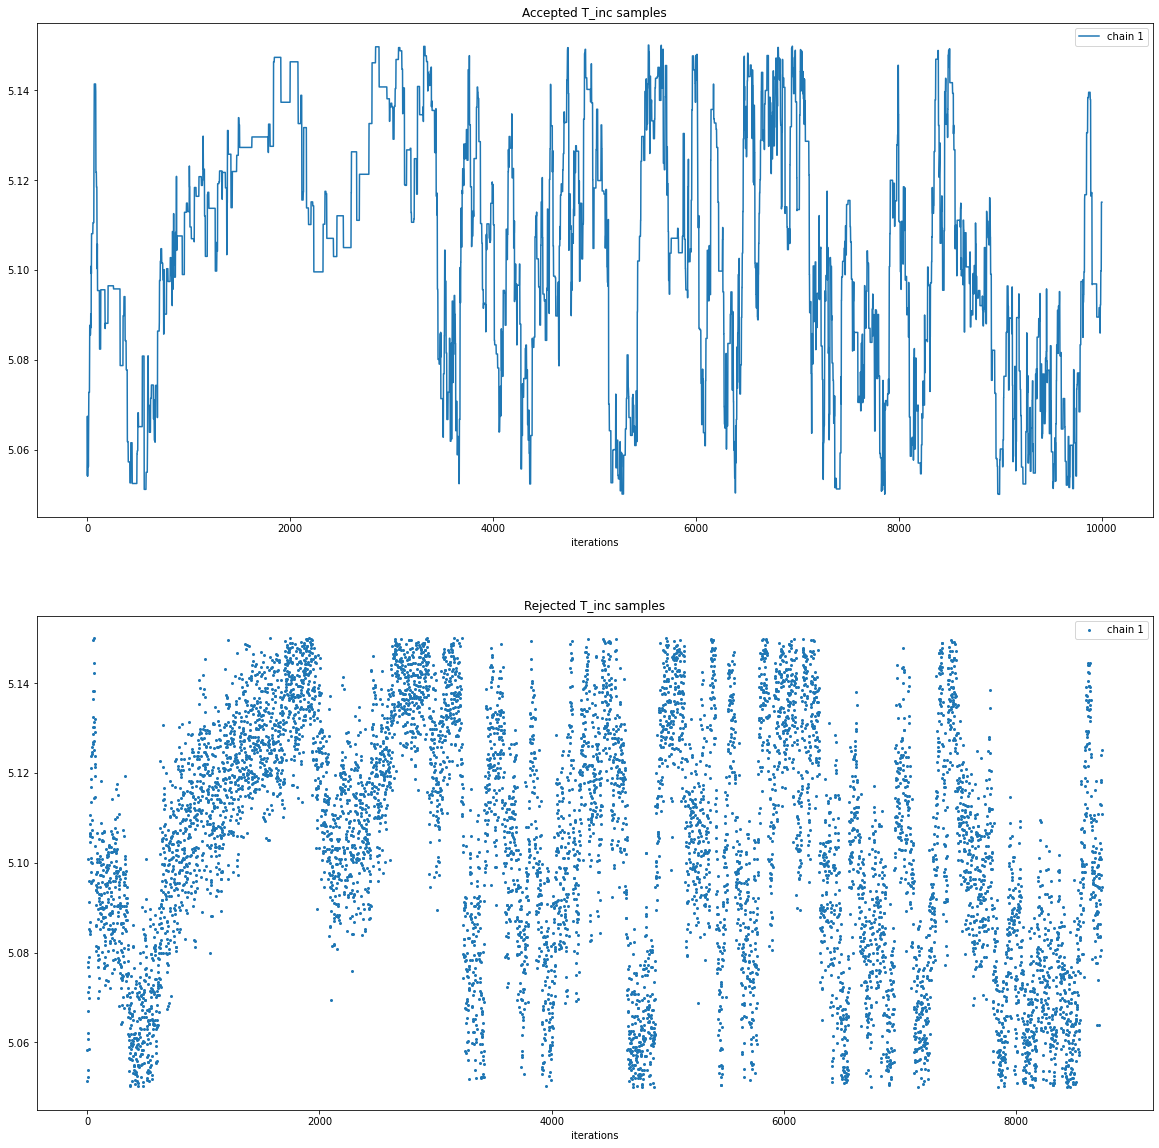

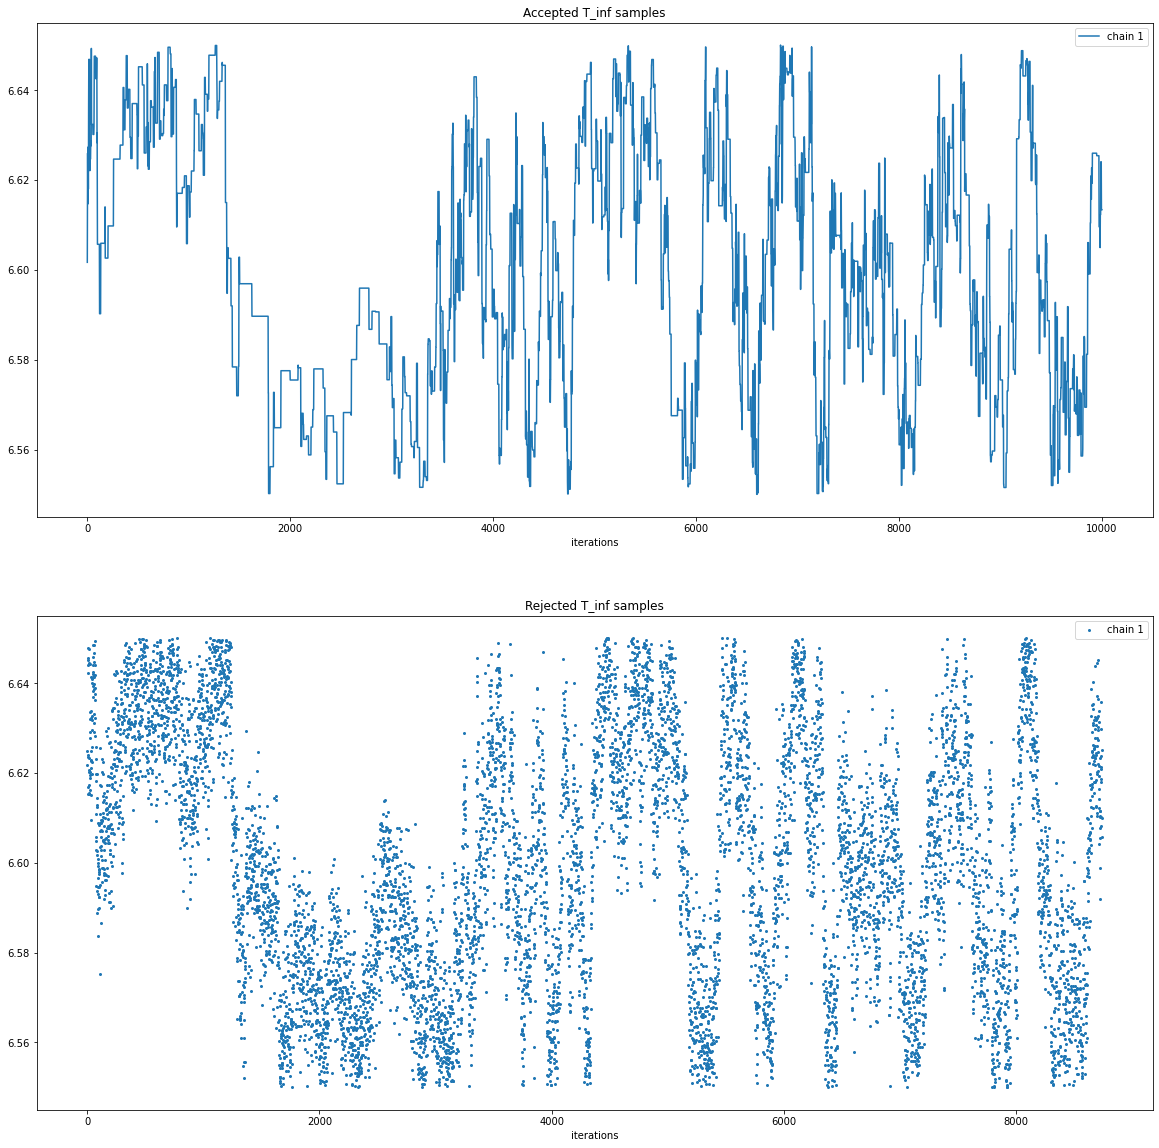

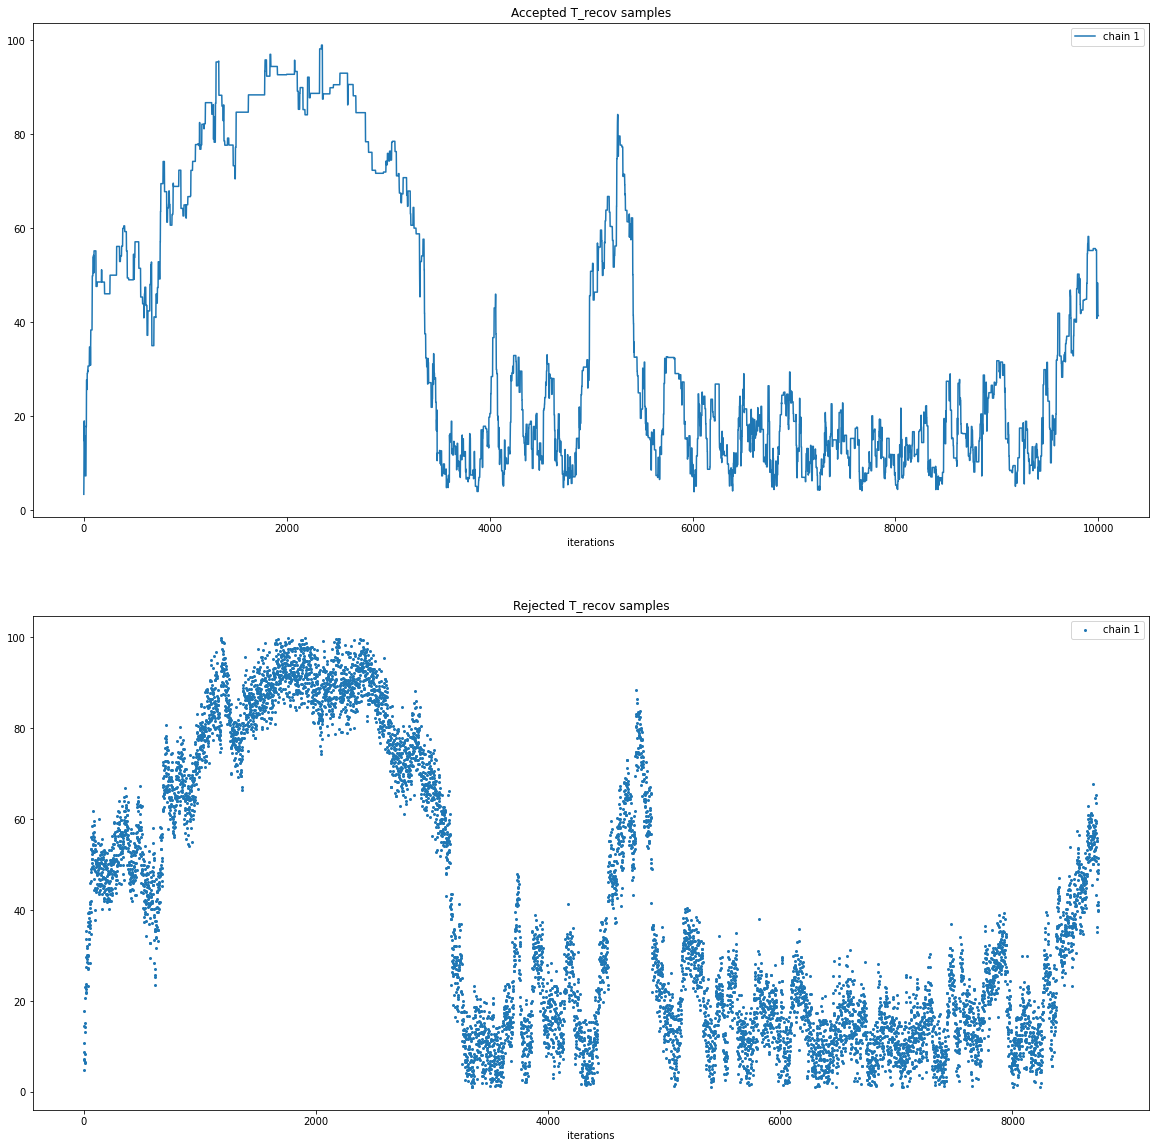

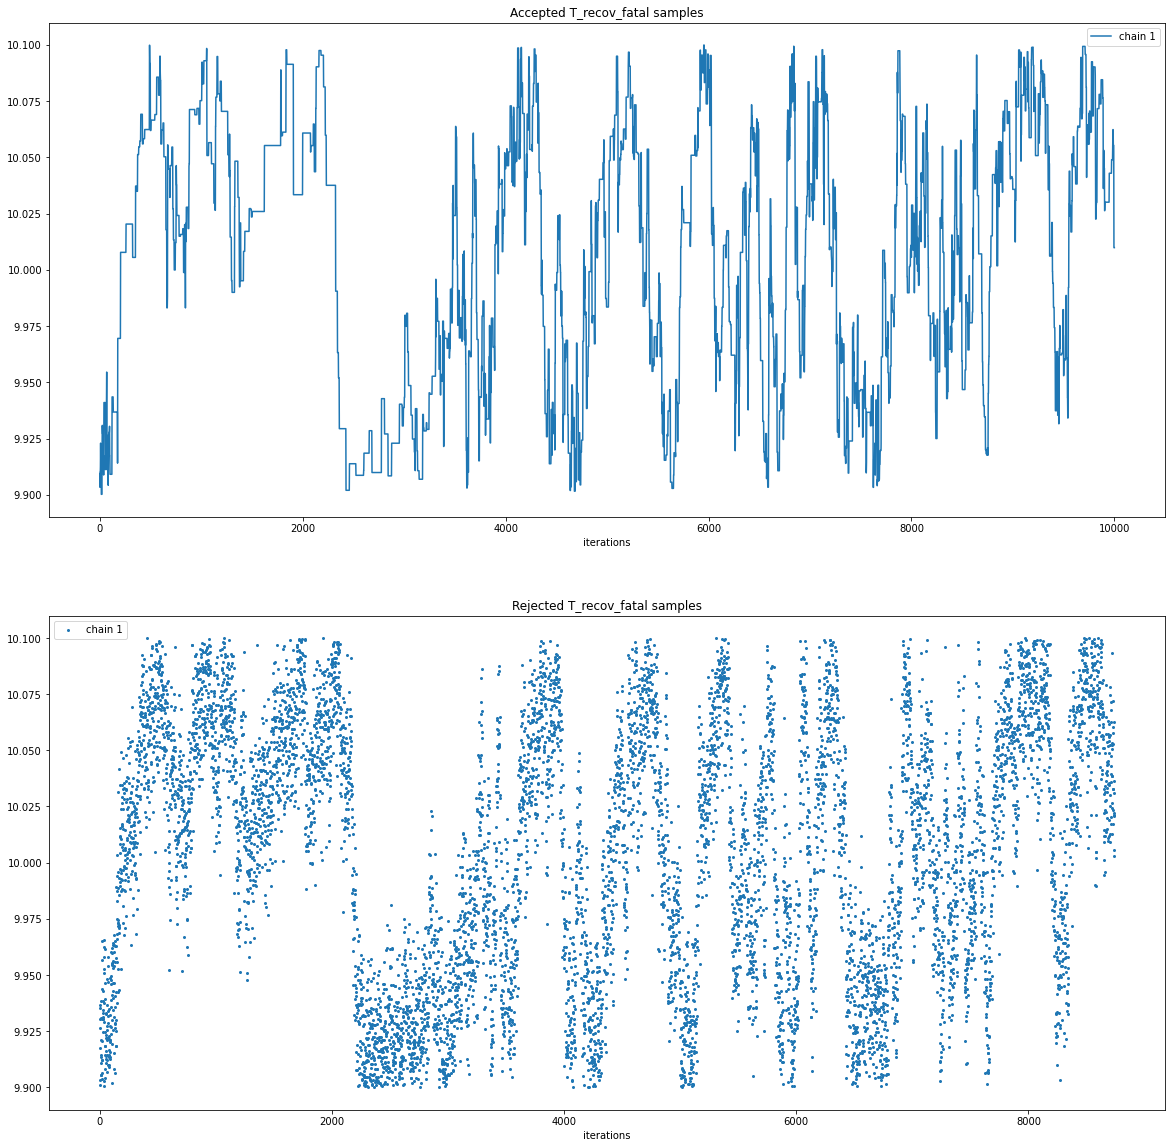

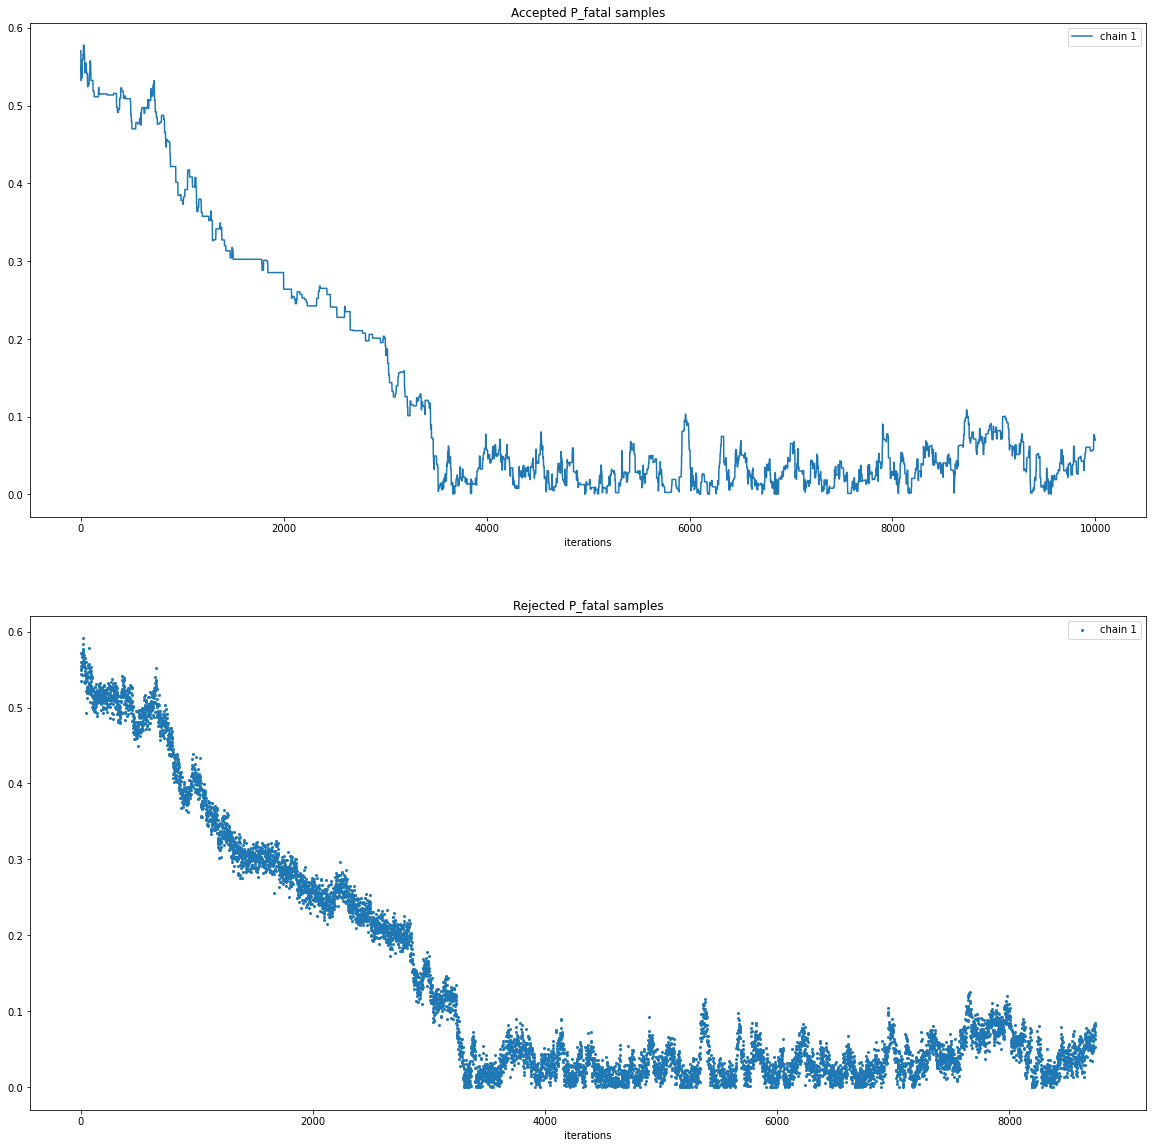

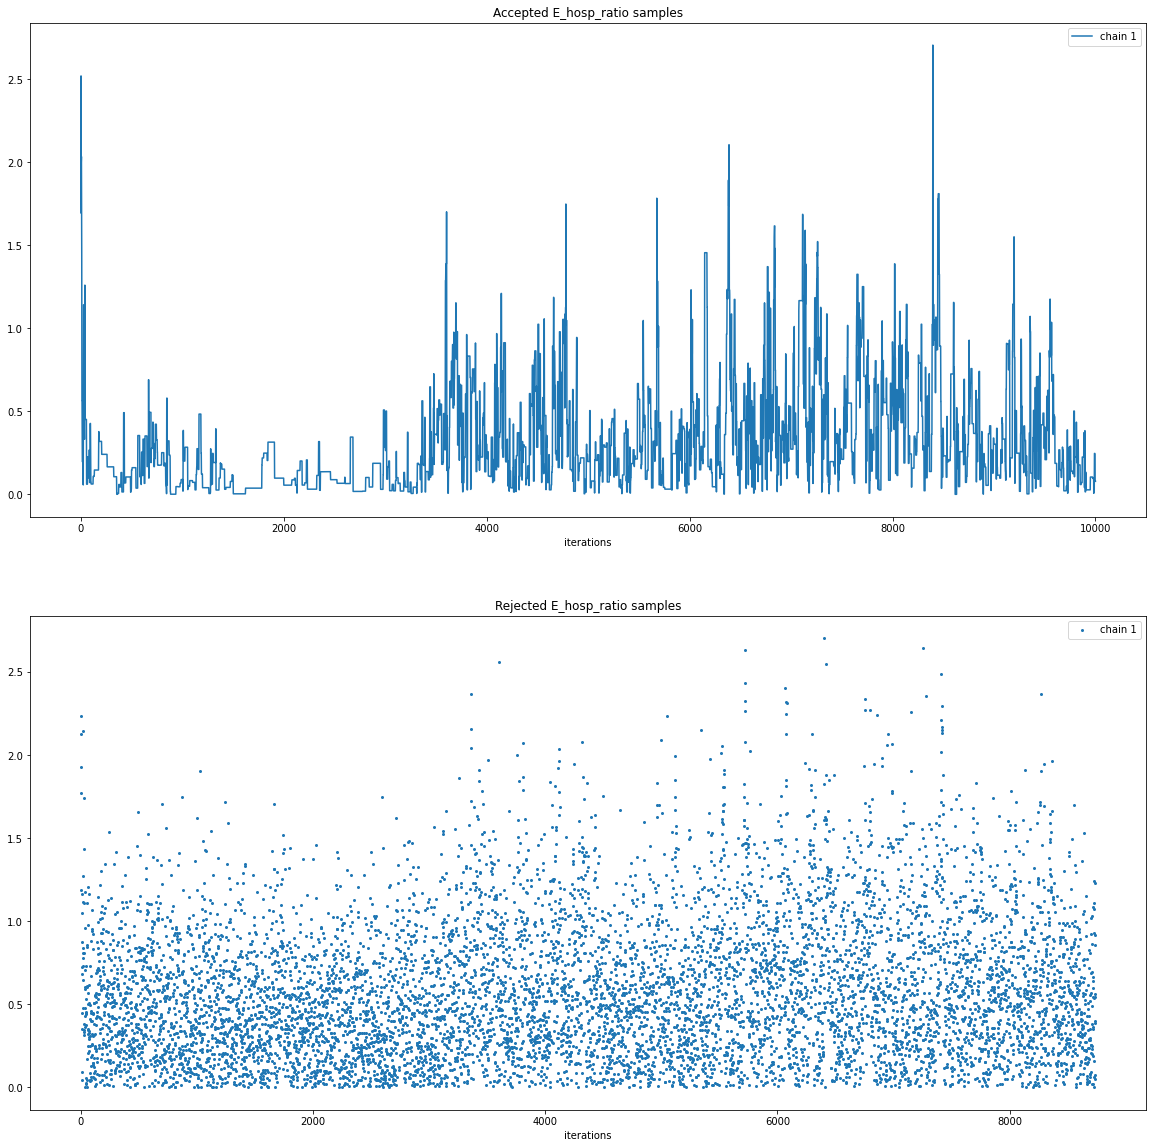

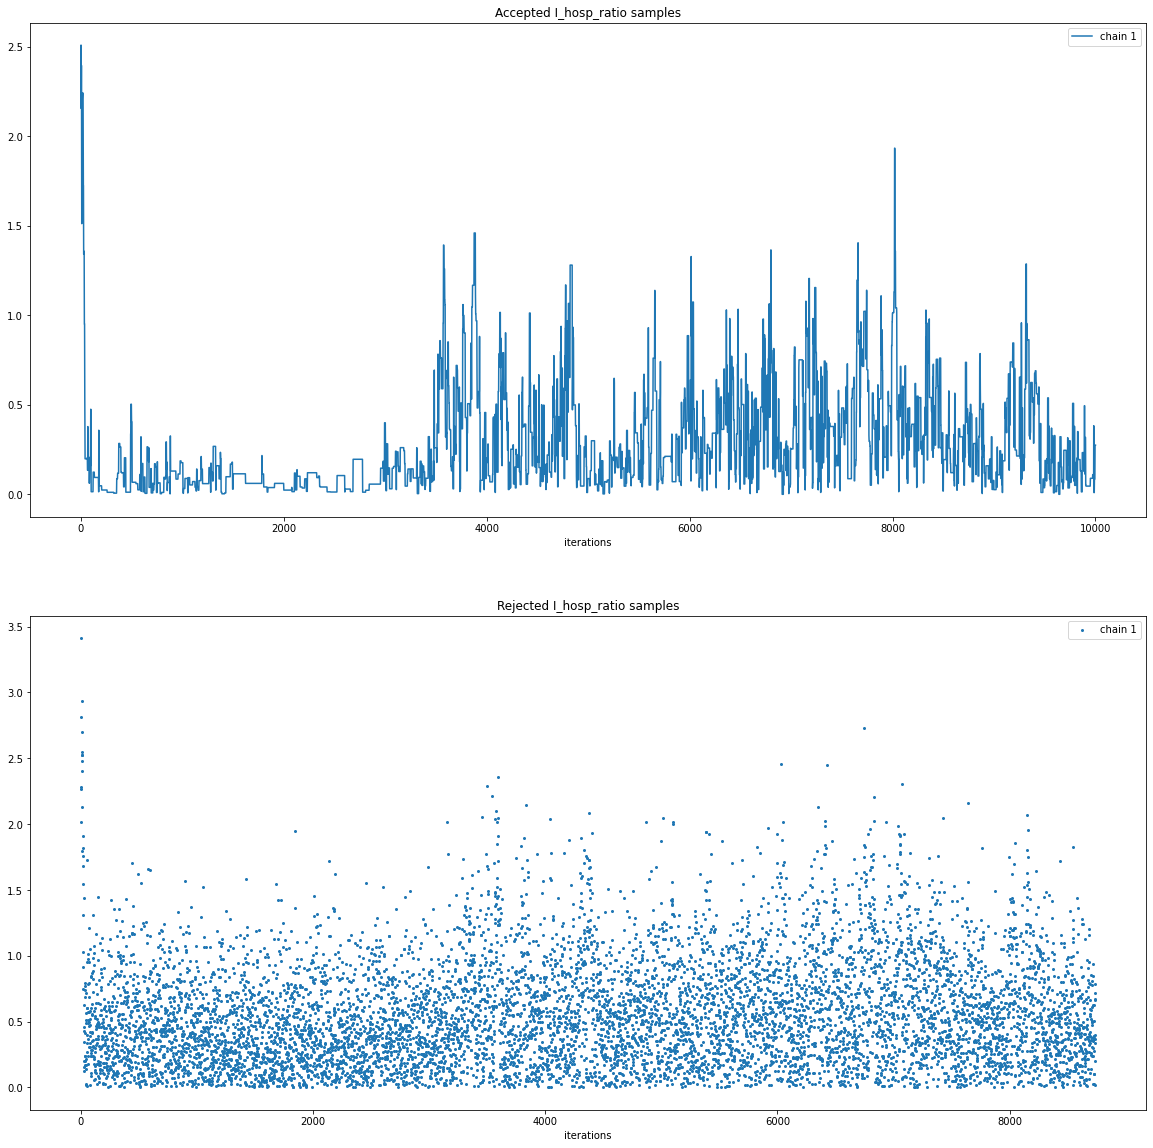

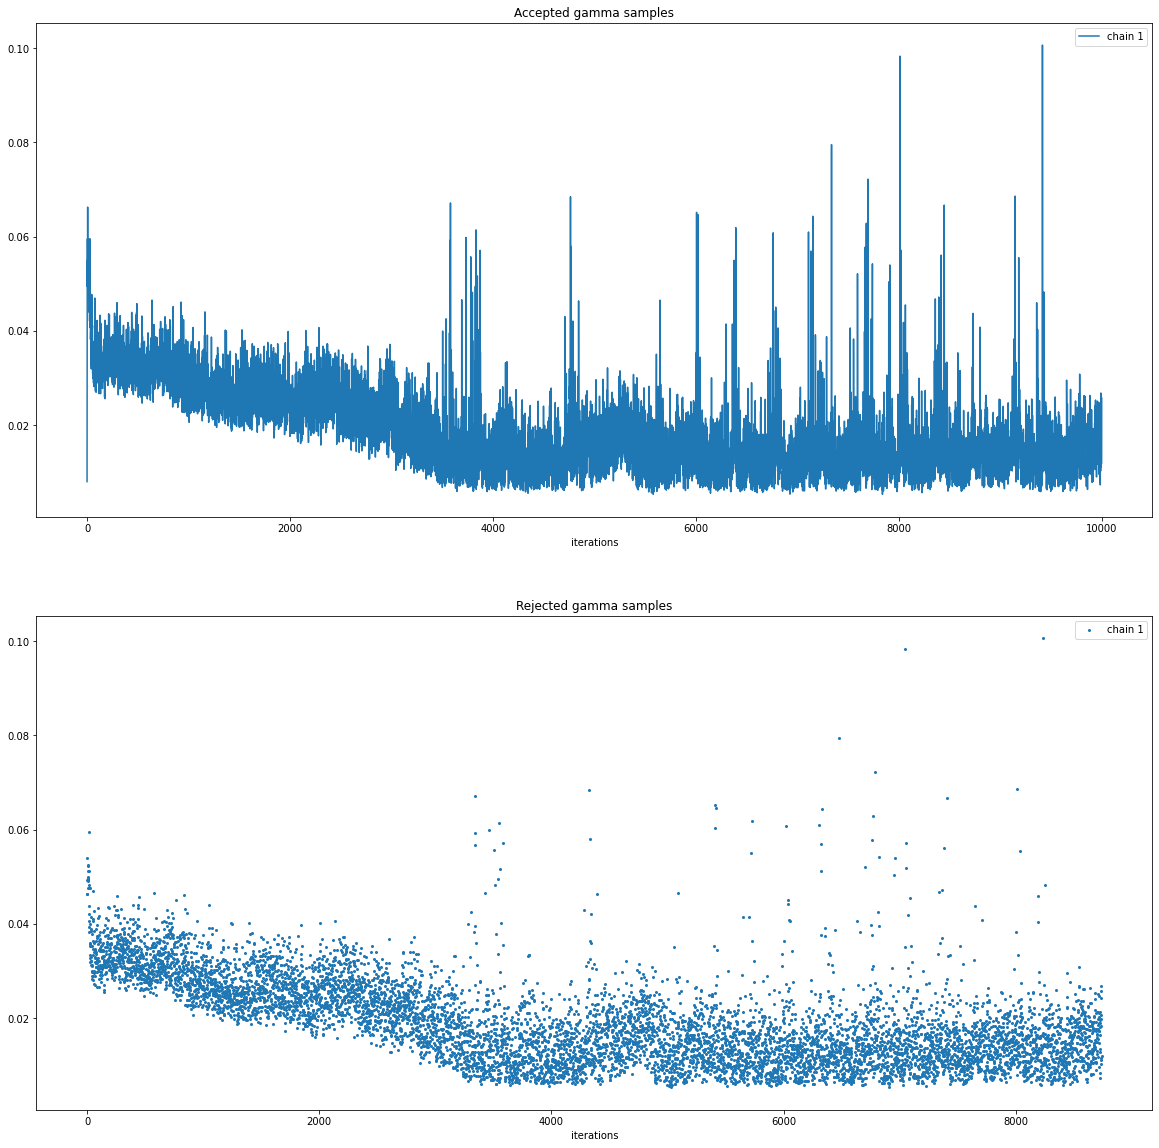

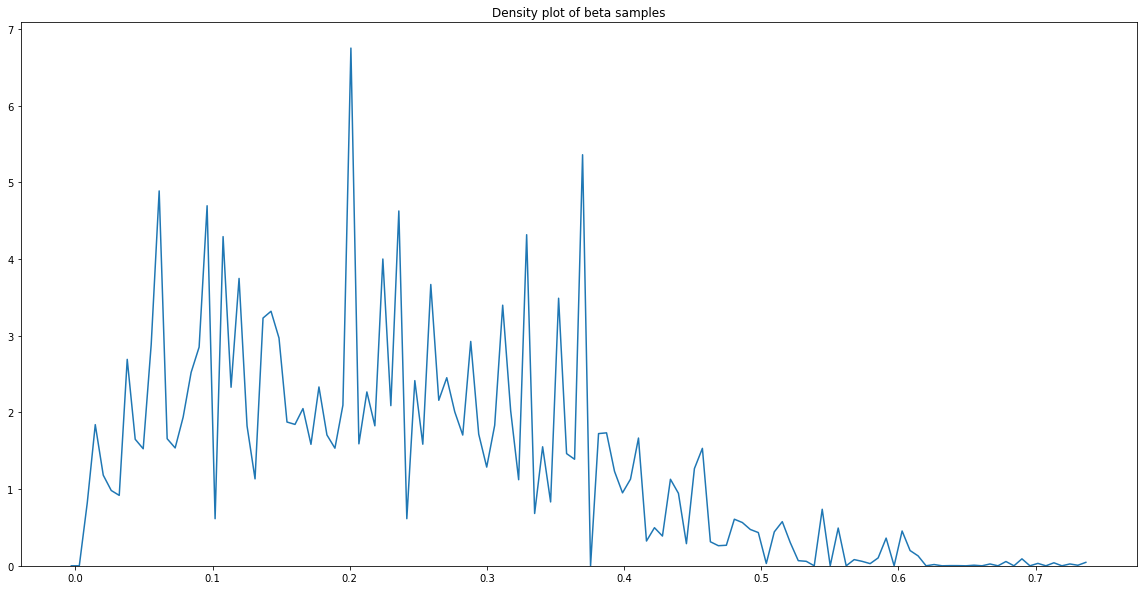

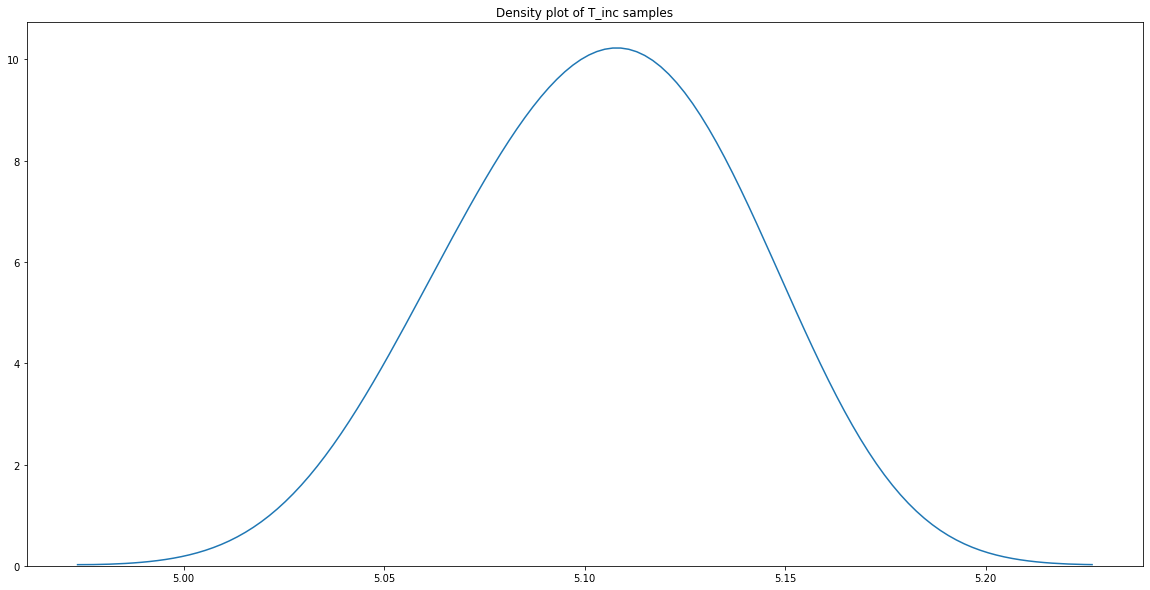

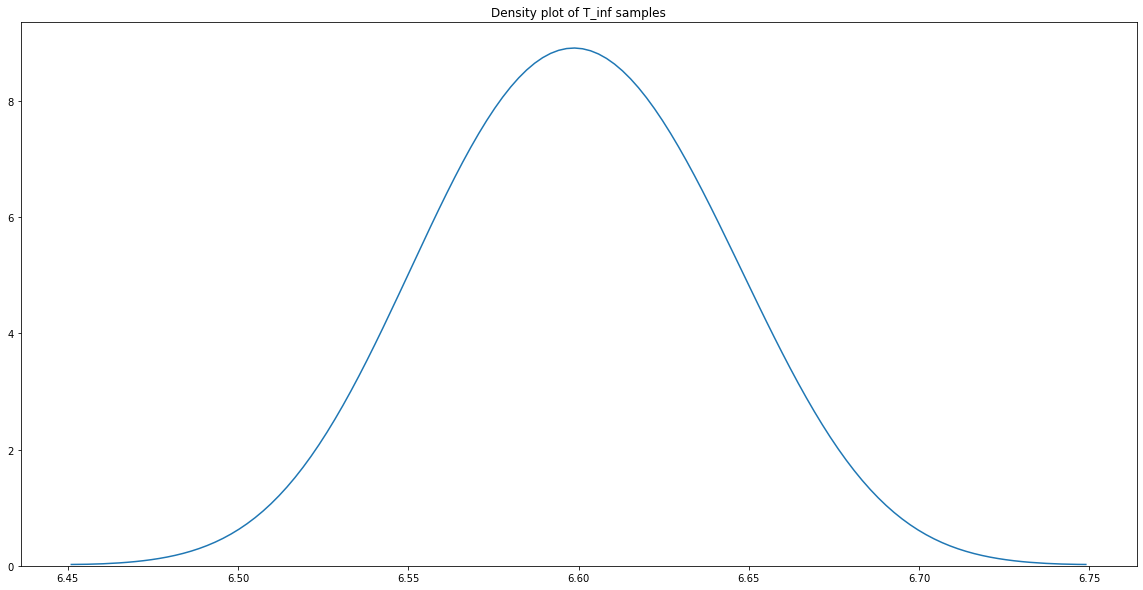

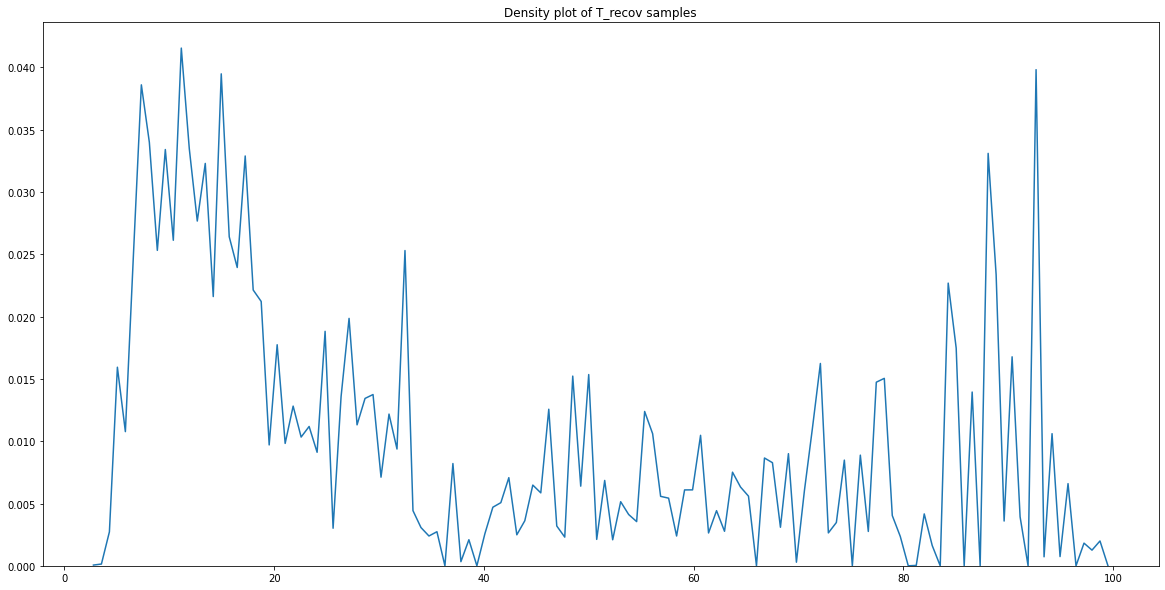

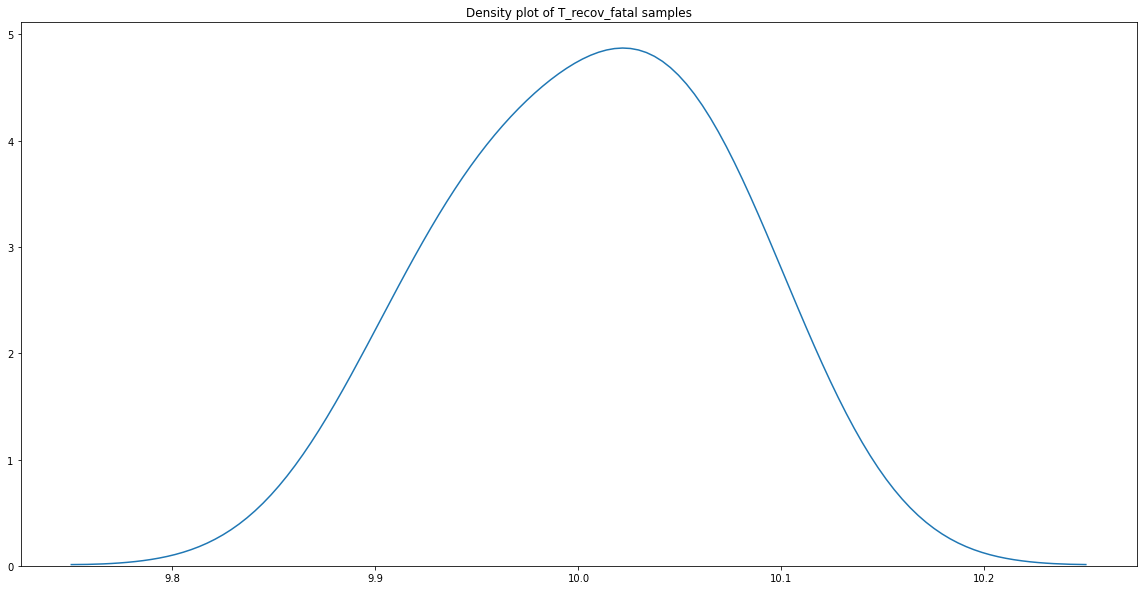

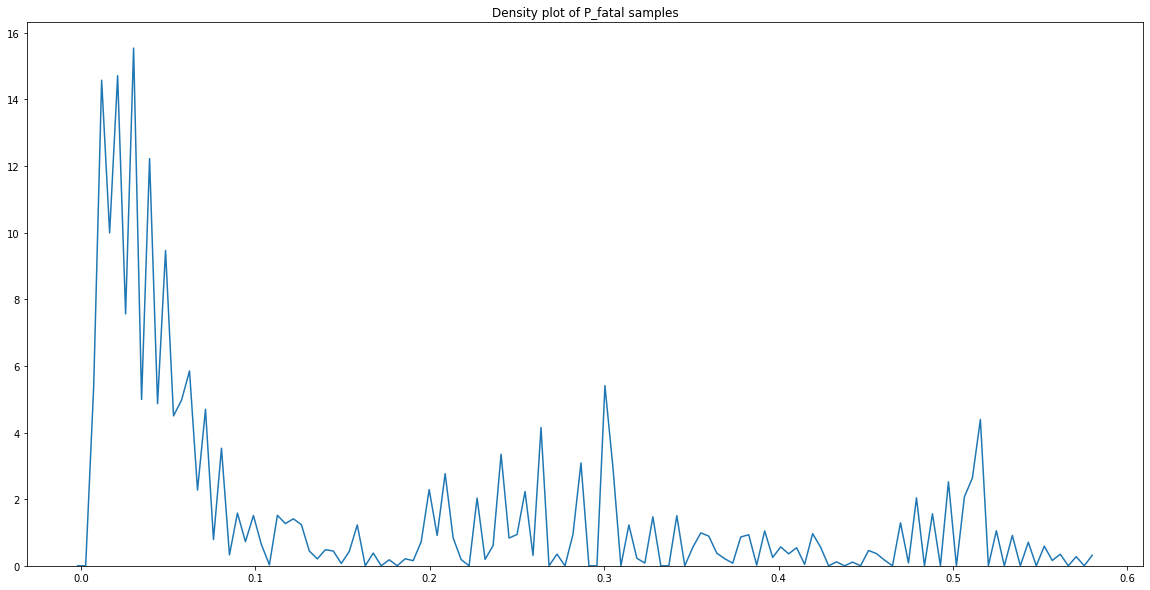

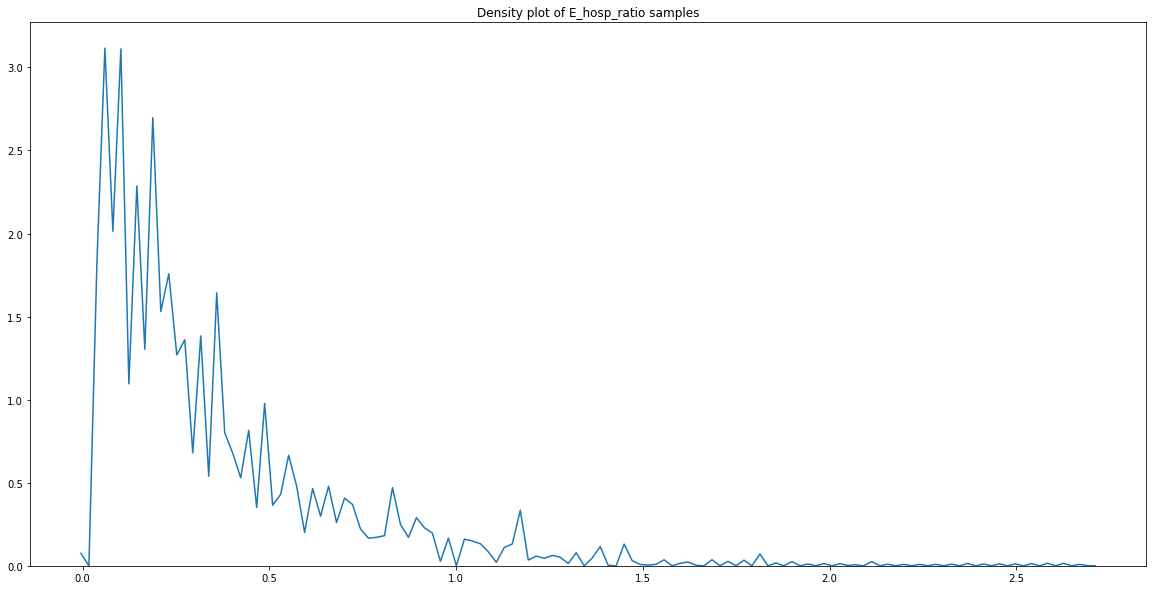

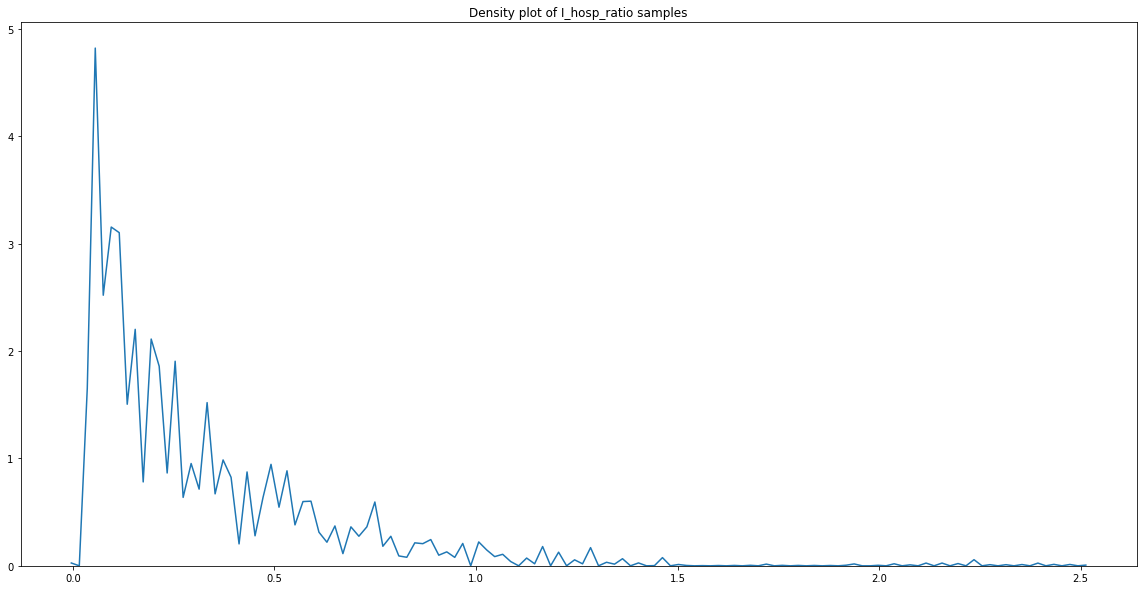

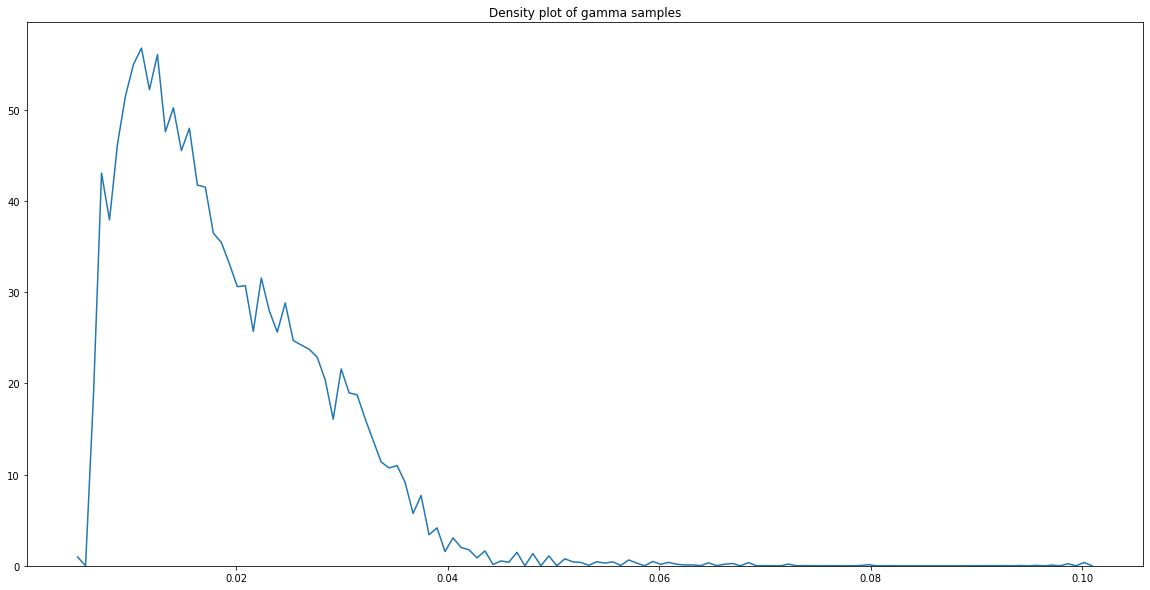

 81%|████████  | 3224/4000 [00:49<00:11, 65.15it/s]


KeyboardInterrupt: 

In [20]:
%%time
predictions_dict['m1'] = single_fitting_cycle(**copy.deepcopy(config['fitting']))

In [ ]:
m2_params = copy.deepcopy(config['fitting'])
m2_params['split']['val_period'] = 0
predictions_dict['m2'] = single_fitting_cycle(**m2_params)

predictions_dict['fitting_date'] = timestamp.strftime("%Y-%m-%d")

In [ ]:
predictions_dict['m1']['best_params']

In [ ]:
predictions_dict['m2']['best_params']

## Loss Dataframes

### M1 Loss DataFrame

In [ ]:
predictions_dict['m1']['df_loss']

### M2 Loss DataFrame

In [ ]:
predictions_dict['m2']['df_loss']

## Sensitivity Plot

In [ ]:
predictions_dict['m1']['plots']['sensitivity'], _, _ = calculate_sensitivity_and_plot(predictions_dict, config, which_fit='m1')
predictions_dict['m2']['plots']['sensitivity'], _, _ = calculate_sensitivity_and_plot(predictions_dict, config, which_fit='m2')

## Plot Forecasts

In [ ]:
predictions_dict['m2']['forecasts'] = {}
predictions_dict['m2']['forecasts']['best'] = get_forecast(predictions_dict, train_fit='m2', 
                                                           model=config['fitting']['model'], 
                                                           forecast_days=config['forecast']['forecast_days'])

predictions_dict['m2']['plots']['forecast_best'] = plot_forecast(predictions_dict, 
                                                                 'test', 
                                                                 error_bars=False)

predictions_dict['m1']['trials_processed'] = forecast_all_trials(predictions_dict, train_fit='m1', 
                                                                 model=config['fitting']['model'], 
                                                                 forecast_days=config['forecast']['forecast_days'])

predictions_dict['m2']['trials_processed'] = forecast_all_trials(predictions_dict, train_fit='m2', 
                                                                 model=config['fitting']['model'], 
                                                                 forecast_days=config['forecast']['forecast_days'])

kforecasts = plot_top_k_trials(predictions_dict, train_fit='m2',
                               k=config['forecast']['num_trials_to_plot'],
                               which_compartments=config['forecast']['plot_topk_trials_for_columns'])
                               
predictions_dict['m2']['plots']['forecasts_topk'] = {}
for column in config['forecast']['plot_topk_trials_for_columns']:
    predictions_dict['m2']['plots']['forecasts_topk'][column.name] = kforecasts[column]

## Uncertainty + Uncertainty Forecasts

In [ ]:
config = read_config(config_filename)

In [ ]:
uncertainty_args = {'predictions_dict': predictions_dict, 'fitting_config': config['fitting'],
                    'forecast_config': config['forecast'], **config['uncertainty']['uncertainty_params']}
                    
uncertainty = config['uncertainty']['method'](**uncertainty_args)

In [ ]:
uncertainty.ensemble_mean_forecast['df_loss']

In [ ]:
uncertainty_forecasts = uncertainty.get_forecasts()
for key in uncertainty_forecasts.keys():
    predictions_dict['m2']['forecasts'][key] = uncertainty_forecasts[key]['df_prediction']
    
predictions_dict['m2']['forecasts']['ensemble_mean'] = uncertainty.ensemble_mean_forecast

In [ ]:
predictions_dict['m2']['beta'] = uncertainty.beta
predictions_dict['m2']['beta_loss'] = uncertainty.beta_loss
predictions_dict['m2']['deciles'] = uncertainty_forecasts

In [ ]:
predictions_dict['m2']['plots']['forecast_best_50'] = plot_forecast(predictions_dict, 
                                                                    (config['fitting']['data']['dataloading_params']['state'], 
                                                                     config['fitting']['data']['dataloading_params']['district']),
                                                                    fits_to_plot=['best', 48.7804878], error_bars=False)
predictions_dict['m2']['plots']['forecast_best_80'] = plot_forecast(predictions_dict, 
                                                                    (config['fitting']['data']['dataloading_params']['state'], 
                                                                     config['fitting']['data']['dataloading_params']['district']),
                                                                    fits_to_plot=['best', 80.48780488], error_bars=False)
predictions_dict['m2']['plots']['forecast_ensemble_mean_50'] = plot_forecast(predictions_dict, 
                                                                             (config['fitting']['data']['dataloading_params']['state'], 
                                                                              config['fitting']['data']['dataloading_params']['district']),
                                                                             fits_to_plot=['ensemble_mean', 48.7804878], error_bars=False)

In [ ]:
config['forecast']['plot_ptiles_for_columns']

In [ ]:
ptiles_plots = plot_ptiles(predictions_dict, which_compartments=config['forecast']['plot_ptiles_for_columns'])
predictions_dict['m2']['plots']['forecasts_ptiles'] = {}
for column in config['forecast']['plot_ptiles_for_columns']:
    predictions_dict['m2']['plots']['forecasts_ptiles'][column.name] = ptiles_plots[column]

## Create Report

In [ ]:
save_dict_and_create_report(predictions_dict, config, ROOT_DIR=output_folder, config_filename=config_filename)

## Create Output CSV

In [ ]:
df_output = create_decile_csv_new(predictions_dict)
df_output.to_csv(f'{output_folder}/deciles.csv')

## Log on W&B

In [ ]:
wandb.init(project="covid-modelling", config=wandb_config)

In [ ]:
log_wandb(predictions_dict)

## Create All Trials Output

In [ ]:
df_all = create_all_trials_csv(predictions_dict)
df_all.to_csv(f'{output_folder}/all_trials.csv')

## Log on MLFlow

In [ ]:
a = {1:[2,3],2:[3,4],3:[4,5]}
b = {1:[4,5],2:[5,6],3:[7,8]}

In [ ]:
a.update(b)

In [ ]:
a


In [ ]:
log_mlflow(config['logging']['experiment_name'], run_name=config['logging']['run_name'], artifact_dir=output_folder)